## 统计TM500 Ticket/Pronto数据

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
'''
数据格式说明：
TM500 Issue List每周由TM500发出，包括目前状态为open的ticket和本周closed的ticket的列表。
注意目前状态为open的ticket不是每周新report的ticket!
'''

# TM500 weekly report路径
report_path = r'D:\TM500\Report\2018' 

try: 
    os.chdir(report_path)
except:
    print("The folder does not exist!")
    
# 获取report文件列表
def get_report_list():
    report_list = glob.glob("./*2018_W*.xlsx")
    if report_list is None:
        print("No files existed!")
    return report_list

# 纠正和统一'Action On'行中的一些拼写便于后面的分类操作
def clean_up_data(data):
    data['Action On'] = data['Action On'].apply(lambda x: x.lower())
    # print(data.groupby('Action On').size())
    data['Action On'].replace('license transfer', 'License Issue', inplace=True)
    data['Action On'].replace('license', 'License Issue', inplace=True)
    data['Action On'].replace('licesne', 'License Issue', inplace=True)
    data['Action On'].replace('lincese', 'License Issue', inplace=True)
    data['Action On'].replace('no fault found', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('no fualt found', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('no fault found.', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('nokia', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('nok', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('enb', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('configuration error', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('hw', 'HW Issue', inplace=True)
    data['Action On'].replace('hardware', 'HW Issue', inplace=True)
    data['Action On'].replace('sw', 'SW Issue', inplace=True)
    data['Action On'].replace('tm500', 'SW Issue', inplace=True)
    data['Action On'].replace('r&d', 'SW Issue', inplace=True)
    data['Action On'].replace('query', 'Query', inplace=True)
    data['Action On'].replace('upgrade', 'Upgrade', inplace=True)
    data['Action On'].replace('script', 'Script Issue', inplace=True)
    # print(data.groupby('Action On').size())
    
    data['Priority'].replace(4, 'Priority 4', inplace=True)
    data['Priority'].replace(3, 'Priority 3', inplace=True)
    data['Priority'].replace(2, 'Priority 2', inplace=True)
    data['Priority'].replace(1, 'Priority-1\n(High Priority)', inplace=True)
    
    # 移除不是LTE相关的ticket  
    data = data[(data['Release Found'].str.startswith("L") == True) | (data['Release Found'].str.startswith("RDA") == True)]
    data.reset_index(inplace=True, drop=True)    
    
    return data

# 从report文件中分别获取open ticket和close ticket数据并以dataframe格式返回
def get_report_data(file):
    report_data = pd.read_excel(file, sheetname=0)
    report_data.dropna(axis=0, how='all', inplace=True)
    report_data.dropna(axis=1, how='all', inplace=True)
    report_data.reset_index(inplace=True, drop=True)  # 重置索引并重新对索引排序
    index = report_data.index[report_data['Priority']=='Tickets closed in this week'] # 找出open ticket和close ticket的分界线
    ticket_opened_data = report_data.iloc[:index.tolist()[0],:]
    ticket_closed_data = report_data.iloc[index.tolist()[0]+1:,:] 
    
    week = re.search(r'.*(W\d+).*', file).group(1)
    
    ticket_opened_data['Opened_Date'] = week
    ticket_opened_data['Closed_Date'] = ''
    ticket_closed_data['Opened_Date'] = week
    ticket_closed_data['Closed_Date'] = week
    # 每个ticket持续时间
    ticket_opened_data['Period'] = ''
    ticket_closed_data['Period'] = ''
    
    return week, ticket_opened_data, ticket_closed_data

# 返回所有report中数据（datafram格式）
def get_report_list_data(report_list):
    ticket_opened_data_list = []
    ticket_closed_data_list = []    
    week_list = []
    
    for report in report_list:
        week, ticket_opened_data, ticket_closed_data = get_report_data(report)
        ticket_opened_data = clean_up_data(ticket_opened_data)
        ticket_closed_data = clean_up_data(ticket_closed_data)        
        week_list.append(week)
        ticket_opened_data_list.append(ticket_opened_data)
        ticket_closed_data_list.append(ticket_closed_data)
         
    return week_list, ticket_opened_data_list, ticket_closed_data_list

# 合并open和close的ticket数据
def combine_data(week_list, ticket_opened_data_list, ticket_closed_data_list):
    opened_data_all = pd.concat(ticket_opened_data_list, axis=0)
    closed_data_all = pd.concat(ticket_closed_data_list, axis=0)
    opened_data_all = opened_data_all.drop_duplicates('Ticket Number')
    for index, row in opened_data_all.iterrows():
        if row['Ticket Number'] in closed_data_all['Ticket Number'].tolist():
            closed_data_all.loc[closed_data_all['Ticket Number']==row['Ticket Number'], 'Opened_Date'] = row['Opened_Date']
            temp = opened_data_all[~opened_data_all['Ticket Number'].isin(closed_data_all['Ticket Number'])]
            ticket_data_comb = pd.concat([closed_data_all, temp])
            ticket_data_comb.reset_index(inplace=True, drop=True)
    
    return ticket_data_comb

# 删除那些close了但是没有在close list中的ticket
def drop_invalid_ticket(data, latest_open_data):
    opened_data = data[data['Closed_Date']=='']
    invalid_data = opened_data[~opened_data['Ticket Number'].isin(latest_open_data['Ticket Number'])]
    
    data = data[~data['Ticket Number'].isin(invalid_data['Ticket Number'])]
    data.reset_index(inplace=True, drop=True)
    
    return data

# 计算每个ticket从open到close的时间
def calc_period(data):
    for index, row in data.iterrows(): 
        if row['Opened_Date'] != '' and row['Closed_Date'] != '':
            row['Period'] = int(row['Closed_Date'].split('W')[1]) - int(row['Opened_Date'].split('W')[1])
            
    return data

# 可视化结果
def visual_data(data):
    ticket_reported_num = [len(data[ticket_data_all['Opened_Date']==date]) for date in week_list]
    ticket_closed_num = [len(data[ticket_data_all['Closed_Date']==date]) for date in week_list]
    ticket_closed_cumsum = [np.cumsum(ticket_closed_num)[i] for i in range(len(ticket_closed_num))]
    ticket_reported_cumsum = [np.cumsum(ticket_reported_num)[i] for i in range(len(ticket_reported_num))]   
    
    print('Total Reported Ticket Number is:', sum(ticket_reported_num))
    print('Total Closed Ticket Number is:', sum(ticket_closed_num))
    
    # 按星期对ticket统计结果可视化
    fig = plt.figure(1,(20,8))
    ax1 = fig.add_subplot(111)
    # bottom参数用于绘制堆叠柱状图
    ax1.bar(week_list, ticket_reported_num, color='#660033', label='Reported Ticket Number') 
    ax1.bar(week_list, ticket_closed_num, bottom=ticket_reported_num, color='#336699', label='Closed Ticket Number')                                   
    # ax1.bar(week_list, ticket_closed_num, bottom=ticket_opened_num, color='#BCEE68', label='Closed Ticket Number')    
    # ax1.bar(week_list, ticket_opened_num, color='#FF83FA', label='Opened Ticket Number')
    ax1.set_xlim(-1,len(week_list)) # 设置x轴第一个tick到y轴之间距离
    ax1.set_ylim(0, np.max(ticket_closed_num)+np.max(ticket_reported_num)+5)  
    ax1.set_xlabel('Week', fontsize=12)
    ax1.set_ylabel('Reported/Closed Ticket Number', fontsize=12)
    ax1.legend(loc=2, fontsize=12)
    ax1.set_title('TM500 Weekly Reported/Closed Ticket Number Stat(2018)', fontsize=15)  
    ax1.yaxis.set_tick_params(labelsize=12) #设置tick label文字大小

    ax2 = ax1.twinx()
    ax2.plot(week_list, ticket_reported_cumsum, 's-', markeredgecolor='r', markerfacecolor='w', lw=2.0, label='Accumulated Reported Ticket Number')
    ax2.plot(week_list, ticket_closed_cumsum, 'D-', markeredgecolor='g', markerfacecolor='w', lw=2.0, label='Accumulated Closed Ticket Number')    
    ax2.set_ylim(0, ticket_reported_cumsum[len(week_list)-1]+100) #
    ax2.set_ylabel('Accumulated Reported/Closed Ticket Number', fontsize=12)
    ax2.legend(loc=1, fontsize=12)
    ax2.yaxis.set_tick_params(labelsize=12) #设置tick label文字大小
    # 设置tick和tick label之间的距离 
    # ax1.tick_params(direction='out', pad=15)
    plt.savefig('TM500_Ticket_Number_2.png', dpi = 600)
    plt.show() 

    # 对总ticket分类统计可视化
    fig = plt.figure(1,(18,10))
    ax1 = fig.add_subplot(121)
    # color1 = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
    color1 = ['#996600', '#CCCC66', '#666600', '#CC3366']
    labeldistance1 = 1.05
    explode1 = (0, 0, 0, 0.05)
    
    # 只对close的ticket的进行统计
    data_closed = data[data['Closed_Date']!='']
    counts_value = data_closed['Priority'].value_counts()
    print(counts_value) # for debug, 保留是为了检查label顺序和统计数据顺序是否一致   
    l = len(counts_value)     
    
    patches1, texts1, autotexts1 = ax1.pie(counts_value, labels=counts_value.index, 
                                           colors=color1[:l], explode=explode1[:l], 
                                           labeldistance=labeldistance1,
                                           autopct='%1.2f%%')
    ax1.axis('equal')
    for t in texts1:
        t.set_size(12)
    for t in autotexts1:
        t.set_size(12)
    # ax1.set_title('TM500 Ticket Priority Distribution', weight='bold', size=12, position=(0.5, 0.96)) 
    # Position是title在这个ax中的位置的比例，比如0.5表示X轴方向正中间位置
    ax1.set_title('TM500 Ticket Priority Distribution', fontsize=15, position=(0.5, 0.96))
            
    ax2 = fig.add_subplot(122)    
    color2 = ['#666699', '#FF9933', '#99CC99', '#CC3366', '#666633', '#CCCC33', '#CC3366']    
    # color2 = ['#99CC33', '#FF9900', '#FFCC00', '#0099CC', '#FFFF66', '#CCCC33', '#FF6600']
    labeldistance2 = 1.05 
    
    counts_value = data_closed['Action On'].value_counts()
    print(counts_value) # for debug, 保留是为了检查label顺序和统计数据顺序是否一致 
    l = len(counts_value)     
    
    patches2, texts2, autotexts2 = ax2.pie(counts_value, labels=counts_value.index, 
                                           colors=color2[:l], labeldistance=labeldistance2,
                                           autopct='%1.2f%%')
    ax2.axis('equal')    
    # 调整label文字和百分比文字的大小
    for t in texts2:
        t.set_size(12)
    for t in autotexts2:
        t.set_size(12)    
    ax2.set_title('TM500 Ticket Category', fontsize=15, position=(0.5, 0.96))
    
    #  fig.tight_layout()
    plt.savefig('TM500_Ticket_category.png', dpi = 600)
    plt.show()
    
    # 对总ticket解决时间period的统计可视化
    fig = plt.figure(1,(18,10))
    print(data_closed['Period'].value_counts())
    print('Average Ticket Period is: {:.1f} Week'.format(data_closed['Period'].mean()))
    ax = data_closed.groupby('Period').size().plot(kind='bar')

Total Reported Ticket Number is: 260
Total Closed Ticket Number is: 249


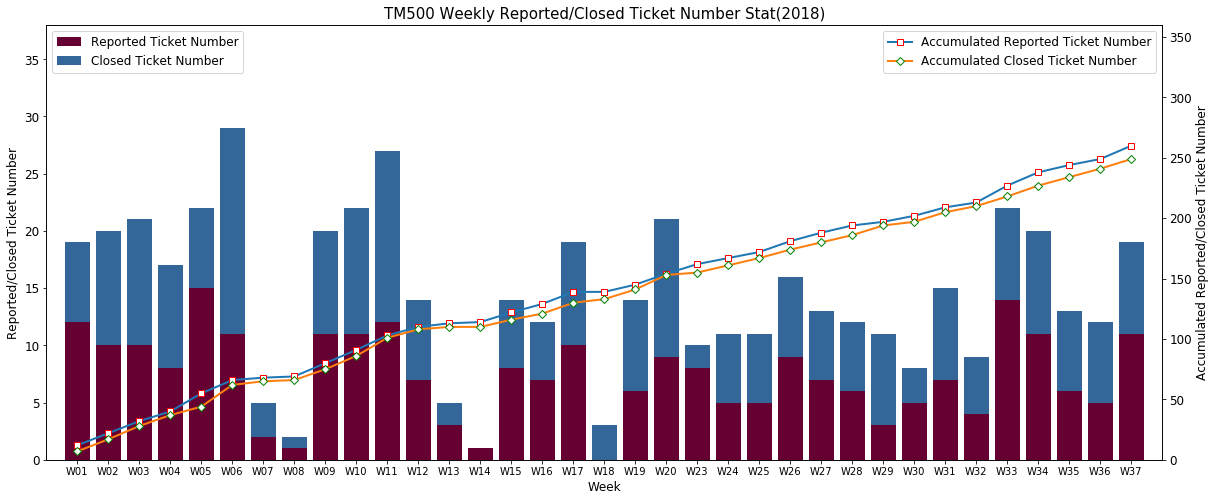

Priority 4                     235
Priority 2                      10
Priority 3                       3
Priority-1\n(High Priority)      1
Name: Priority, dtype: int64
Not TM500 Issue    151
Query               60
HW Issue            15
License Issue       13
SW Issue             7
svc                  2
enhancement          1
Name: Action On, dtype: int64


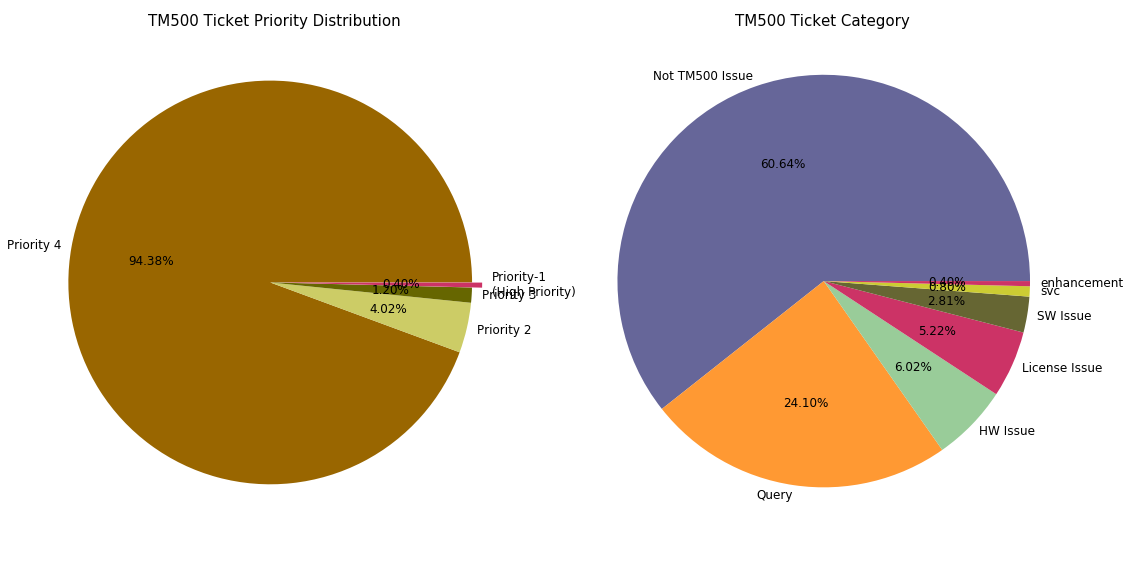

0     155
1      64
2      14
3       8
4       3
6       2
16      1
13      1
9       1
Name: Period, dtype: int64
Average Ticket Period is: 0.7 Week


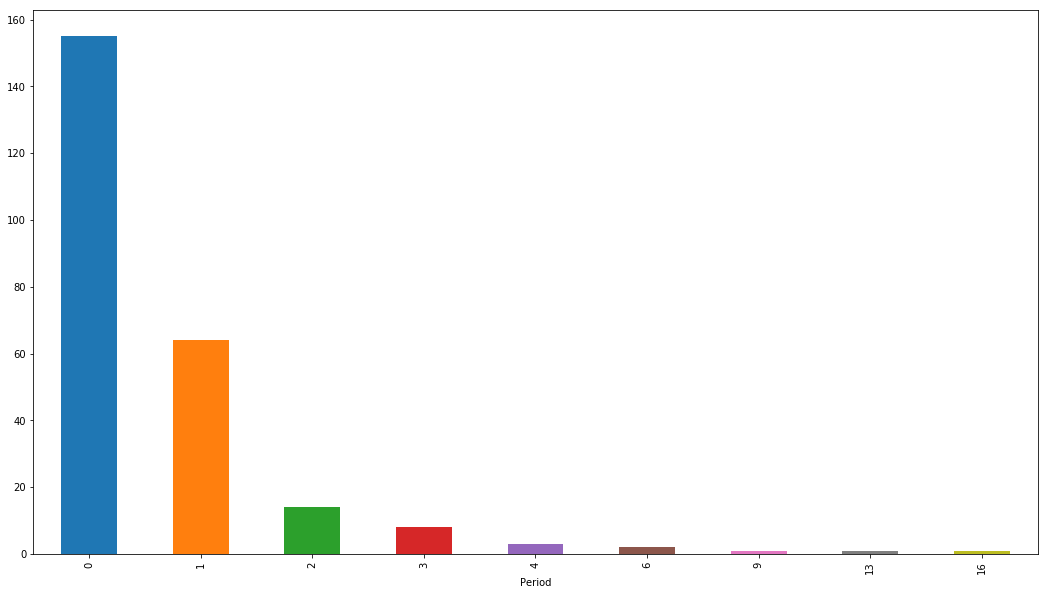

In [3]:
report_list = get_report_list()
week_list, ticket_opened_data_list, ticket_closed_data_list = get_report_list_data(report_list)
ticket_data_all = combine_data(week_list, ticket_opened_data_list, ticket_closed_data_list)
ticket_data_all = drop_invalid_ticket(ticket_data_all, ticket_opened_data_list[-1])
ticket_data_all = calc_period(ticket_data_all)
visual_data(ticket_data_all) 